In [2]:
from __future__ import print_function
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import shutil
import math
import time
import matplotlib.pyplot as plt
from memory_profiler import memory_usage

In [3]:
seed = 1
cuda = torch.cuda.is_available()
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

batch_size = 100
test_batch_size = 100
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)


100%|██████████| 170498071/170498071 [00:03<00:00, 49449084.39it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
class vgg(nn.Module):

    def __init__(self, dataset='cifar10', init_weights=True, cfg=None):
        super(vgg, self).__init__()
        if cfg is None:
            cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512]
        self.feature = self.make_layers(cfg, True)

        if dataset == 'cifar100':
            num_classes = 100
        elif dataset == 'cifar10':
            num_classes = 10
        self.classifier = nn.Linear(cfg[-1], num_classes)
        if init_weights:
            self._initialize_weights()

    def make_layers(self, cfg, batch_norm=False):
        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1, bias=False)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.feature(x)
        x = nn.AvgPool2d(2)(x)
        x = x.view(x.size(0), -1)
        y = self.classifier(x)
        return y

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                if n != 0:  # Check if n is not zero
                    m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(0.5)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

In [5]:
refine = ''

if refine:
    checkpoint = torch.load(refine)
    model = vgg(cfg=checkpoint['cfg'])
    model.cuda()
    model.load_state_dict(checkpoint['state_dict'])
else:
    model = vgg()
if cuda:
    model.cuda()

In [6]:
lr = 0.1
momentum = 0.9
weight_decay = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

resume = ''

if resume:
    if os.path.isfile(resume):
        print("=> loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume)
        start_epoch = checkpoint['epoch']
        best_prec1 = checkpoint['best_prec1']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {}) Prec1: {:f}"
              .format(resume, checkpoint['epoch'], best_prec1))
    else:
        print("=> no checkpoint found at '{}'".format(resume))

In [7]:
s = 0.0001
# additional subgradient descent on the sparsity-induced penalty term
def updateBN():
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.weight.grad.data.add_(s*torch.sign(m.weight.data))  # L1
            
def updateLpBN(a):
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.weight.grad.data.add_(s*(a*torch.sign(m.weight.data)/(m.weight.data.abs()**(1-a))))

def updateTL1BN(a):
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.weight.grad.data.add_(s*a*(a+1)*torch.sign(m.weight.data)/(a+m.weight.data.abs())**2)  #TL1

In [8]:
sr = False
log_interval = 100
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        if sr:
            updateBN()
#             a = 0.5
#             updateTL1BN(a)
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [9]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
            with torch.no_grad():
                data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / float(len(test_loader.dataset))

In [10]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

# **Training and Testing the VGG model on CIFAR-10**

In [11]:
# list for accuracy
accuracy_list = []
epoch_list = []

In [12]:
epochs = 20
start_epoch = 0

best_prec1 = 0.
for epoch in range(start_epoch, epochs):
    if epoch in [epochs*0.5, epochs*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
    train(epoch)
    prec1 = test()
    accuracy_list.append(prec1)
    epoch_list.append(int(epoch))
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_prec1': best_prec1,
        'optimizer': optimizer.state_dict(),
    }, is_best)

Train Epoch: 0 [0/50000 (0.0%)]	Loss: 2.302786
Train Epoch: 0 [10000/50000 (20.0%)]	Loss: 1.635774
Train Epoch: 0 [20000/50000 (40.0%)]	Loss: 1.558715
Train Epoch: 0 [30000/50000 (60.0%)]	Loss: 1.472934
Train Epoch: 0 [40000/50000 (80.0%)]	Loss: 1.318596

Test set: Average loss: 1.1456, Accuracy: 5839/10000 (58.4%)

Train Epoch: 1 [0/50000 (0.0%)]	Loss: 1.335097
Train Epoch: 1 [10000/50000 (20.0%)]	Loss: 1.061004
Train Epoch: 1 [20000/50000 (40.0%)]	Loss: 1.012286
Train Epoch: 1 [30000/50000 (60.0%)]	Loss: 1.037736
Train Epoch: 1 [40000/50000 (80.0%)]	Loss: 1.021137

Test set: Average loss: 0.8945, Accuracy: 6897/10000 (69.0%)

Train Epoch: 2 [0/50000 (0.0%)]	Loss: 0.977222
Train Epoch: 2 [10000/50000 (20.0%)]	Loss: 0.756232
Train Epoch: 2 [20000/50000 (40.0%)]	Loss: 0.833479
Train Epoch: 2 [30000/50000 (60.0%)]	Loss: 0.741784
Train Epoch: 2 [40000/50000 (80.0%)]	Loss: 0.838412

Test set: Average loss: 1.0604, Accuracy: 6711/10000 (67.1%)

Train Epoch: 3 [0/50000 (0.0%)]	Loss: 0.483773

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[tensor(0.5839), tensor(0.6897), tensor(0.6711), tensor(0.7219), tensor(0.7844), tensor(0.7579), tensor(0.7902), tensor(0.8108), tensor(0.8237), tensor(0.8232), tensor(0.8927), tensor(0.8966), tensor(0.8965), tensor(0.8986), tensor(0.9001), tensor(0.9025), tensor(0.9037), tensor(0.9045), tensor(0.9042), tensor(0.9058)]


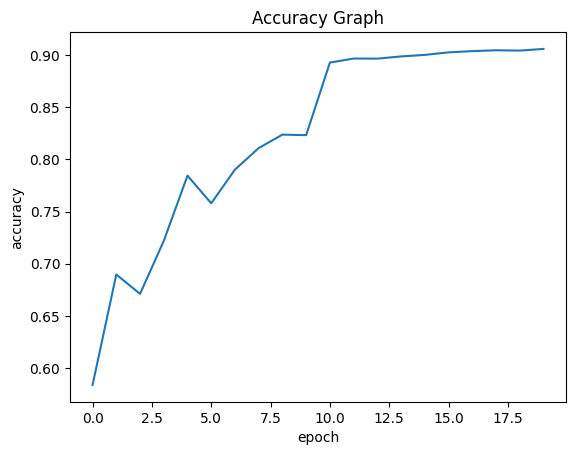

In [13]:
print(epoch_list)
print(accuracy_list)
# plot the accuracy graph
plt.plot(epoch_list, accuracy_list)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Graph')
plt.show()

# **Training and Testing the VGG model with Sparsity**

In [14]:
sr = True
s = 0.0001

In [15]:
# list for accuracy
accuracy_list = []
epoch_list = []


epochs = 20
start_epoch = 0

best_prec1 = 0.
for epoch in range(start_epoch, epochs):
    if epoch in [epochs*0.5, epochs*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
    train(epoch)
    prec1 = test()
    accuracy_list.append(prec1)
    epoch_list.append(int(epoch))
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_prec1': best_prec1,
        'optimizer': optimizer.state_dict(),
    }, is_best)

Train Epoch: 0 [0/50000 (0.0%)]	Loss: 0.175336
Train Epoch: 0 [10000/50000 (20.0%)]	Loss: 0.177340
Train Epoch: 0 [20000/50000 (40.0%)]	Loss: 0.149993
Train Epoch: 0 [30000/50000 (60.0%)]	Loss: 0.132684
Train Epoch: 0 [40000/50000 (80.0%)]	Loss: 0.123648

Test set: Average loss: 0.3032, Accuracy: 9058/10000 (90.6%)

Train Epoch: 1 [0/50000 (0.0%)]	Loss: 0.164246
Train Epoch: 1 [10000/50000 (20.0%)]	Loss: 0.067474
Train Epoch: 1 [20000/50000 (40.0%)]	Loss: 0.192861
Train Epoch: 1 [30000/50000 (60.0%)]	Loss: 0.075392
Train Epoch: 1 [40000/50000 (80.0%)]	Loss: 0.101059

Test set: Average loss: 0.3028, Accuracy: 9055/10000 (90.6%)

Train Epoch: 2 [0/50000 (0.0%)]	Loss: 0.105313
Train Epoch: 2 [10000/50000 (20.0%)]	Loss: 0.165909
Train Epoch: 2 [20000/50000 (40.0%)]	Loss: 0.115333
Train Epoch: 2 [30000/50000 (60.0%)]	Loss: 0.199461
Train Epoch: 2 [40000/50000 (80.0%)]	Loss: 0.201399

Test set: Average loss: 0.3030, Accuracy: 9056/10000 (90.6%)

Train Epoch: 3 [0/50000 (0.0%)]	Loss: 0.131553

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[tensor(0.9058), tensor(0.9055), tensor(0.9056), tensor(0.9053), tensor(0.9058), tensor(0.9067), tensor(0.9062), tensor(0.9054), tensor(0.9060), tensor(0.9071), tensor(0.9072), tensor(0.9063), tensor(0.9067), tensor(0.9079), tensor(0.9073), tensor(0.9065), tensor(0.9069), tensor(0.9072), tensor(0.9076), tensor(0.9074)]


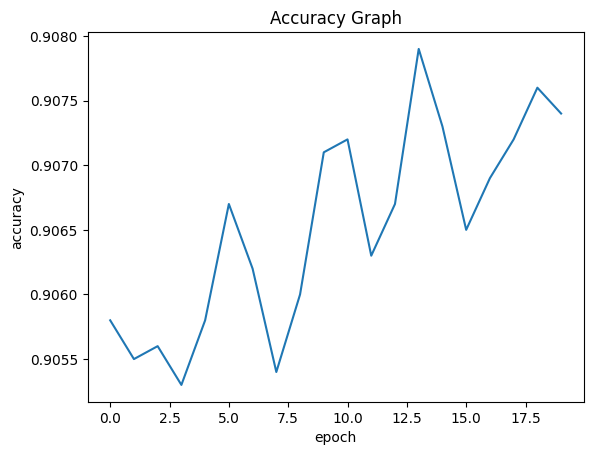

In [16]:
print(epoch_list)
print(accuracy_list)
# plot the accuracy graph
plt.plot(epoch_list, accuracy_list)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Graph')
plt.show()

# **Pruning and Finetuning on various Pruning Percentages**

Iteration:  0 Percent:  0.0
=> loading checkpoint '/kaggle/working/model_best.pth.tar'
=> loaded checkpoint '/kaggle/working/model_best.pth.tar' (epoch 14) Prec1: 0.907900
vgg(
  (feature): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): B

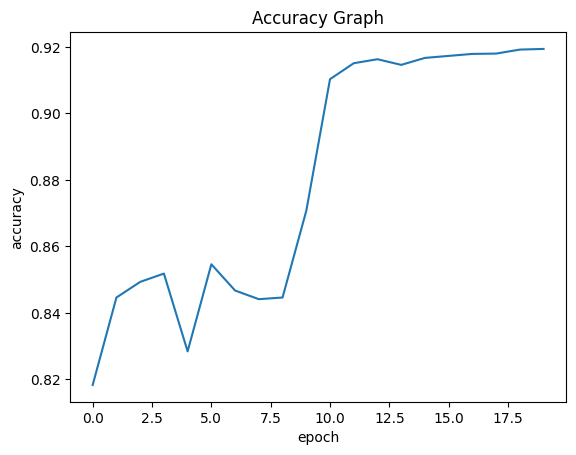

--------------------------------------------------
--------------------------------------------------
Iteration:  1 Percent:  0.1
=> loading checkpoint '/kaggle/working/model_best.pth.tar'
=> loaded checkpoint '/kaggle/working/model_best.pth.tar' (epoch 14) Prec1: 0.907900
vgg(
  (feature): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)

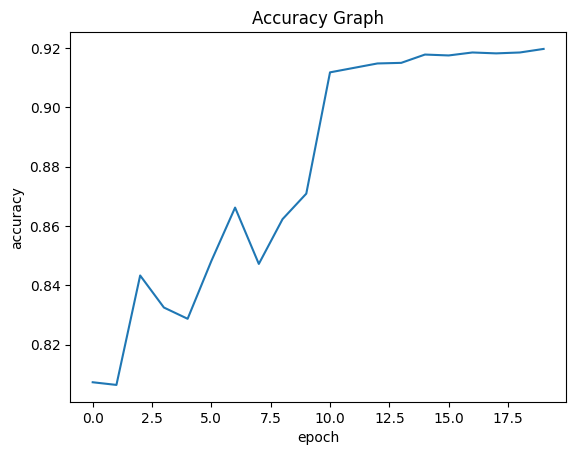

--------------------------------------------------
--------------------------------------------------
Iteration:  2 Percent:  0.2
=> loading checkpoint '/kaggle/working/model_best.pth.tar'
=> loaded checkpoint '/kaggle/working/model_best.pth.tar' (epoch 14) Prec1: 0.907900
vgg(
  (feature): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)

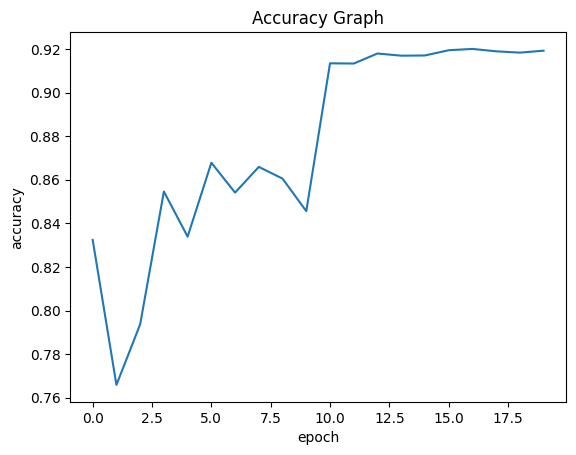

--------------------------------------------------
--------------------------------------------------
Iteration:  3 Percent:  0.3
=> loading checkpoint '/kaggle/working/model_best.pth.tar'
=> loaded checkpoint '/kaggle/working/model_best.pth.tar' (epoch 14) Prec1: 0.907900
vgg(
  (feature): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)

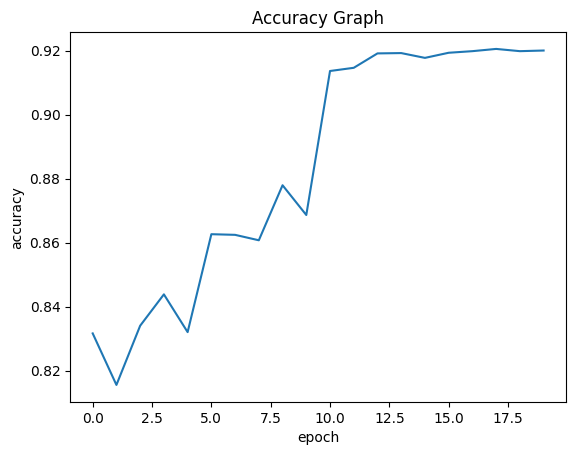

--------------------------------------------------
--------------------------------------------------
Iteration:  4 Percent:  0.4
=> loading checkpoint '/kaggle/working/model_best.pth.tar'
=> loaded checkpoint '/kaggle/working/model_best.pth.tar' (epoch 14) Prec1: 0.907900
vgg(
  (feature): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)

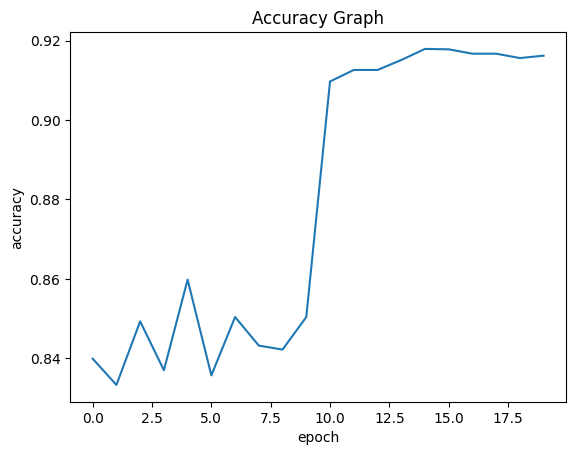

--------------------------------------------------
--------------------------------------------------
Iteration:  5 Percent:  0.5
=> loading checkpoint '/kaggle/working/model_best.pth.tar'
=> loaded checkpoint '/kaggle/working/model_best.pth.tar' (epoch 14) Prec1: 0.907900
vgg(
  (feature): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)

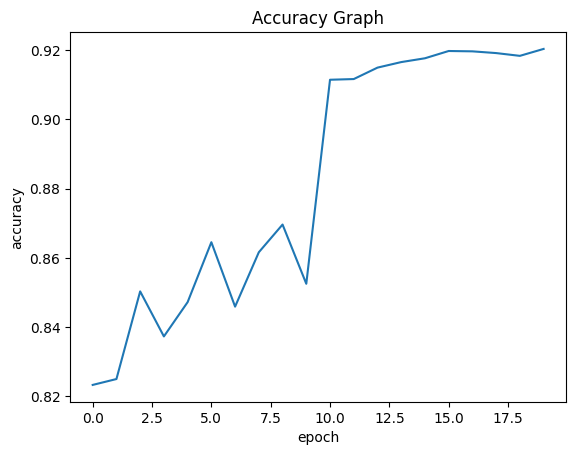

--------------------------------------------------
--------------------------------------------------
Iteration:  6 Percent:  0.6
=> loading checkpoint '/kaggle/working/model_best.pth.tar'
=> loaded checkpoint '/kaggle/working/model_best.pth.tar' (epoch 14) Prec1: 0.907900
vgg(
  (feature): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)

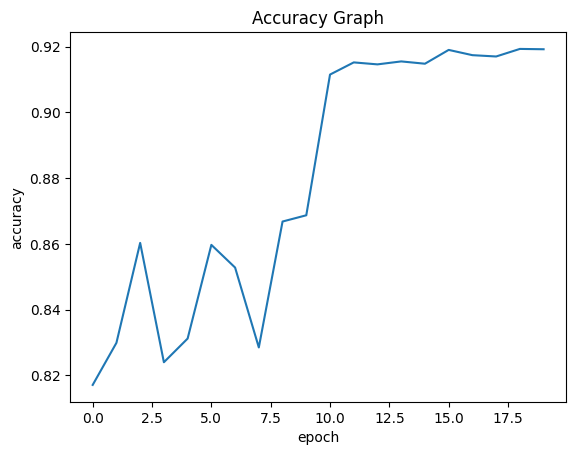

--------------------------------------------------
--------------------------------------------------
Iteration:  7 Percent:  0.7
=> loading checkpoint '/kaggle/working/model_best.pth.tar'
=> loaded checkpoint '/kaggle/working/model_best.pth.tar' (epoch 14) Prec1: 0.907900
vgg(
  (feature): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)

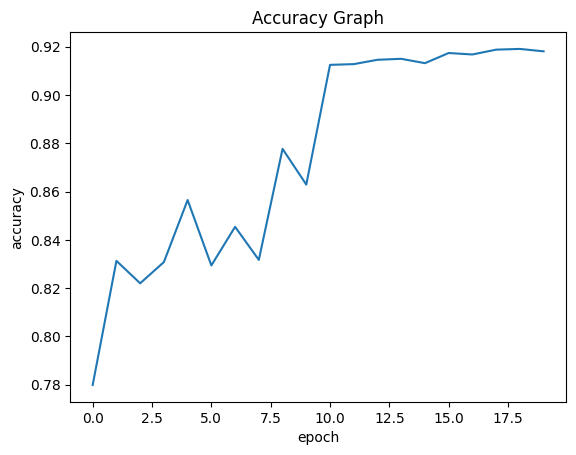

--------------------------------------------------
--------------------------------------------------


In [35]:
percent_arr = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
percent_accuracy_list = []
percent_num_param_list = []
percent_model_size_list = []
percent_elapsed_time_list = []
percent_run_time_memory_list = []
model_path = '/kaggle/working/model_best.pth.tar'
save = 'pruned.pth.tar'
for idx, percent in enumerate(percent_arr):
    print('Iteration: ', idx, 'Percent: ', percent)
    model = vgg()
    if cuda:
        model.cuda()
    if model_path:
        if os.path.isfile(model_path):
            print("=> loading checkpoint '{}'".format(model_path))
            checkpoint = torch.load(model_path)
            start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {}) Prec1: {:f}"
                  .format(model_path, checkpoint['epoch'], best_prec1))
        else:
            print("=> no checkpoint found at '{}'".format(resume))

    print(model)

    total = 0
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            total += m.weight.data.shape[0]

    bn = torch.zeros(total)
    index = 0
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            size = m.weight.data.shape[0]
            bn[index:(index+size)] = m.weight.data.abs().clone()
            index += size

    y, i = torch.sort(bn)
    thre_index = int(total * percent)
    thre = y[thre_index]

    pruned = 0
    cfg = []
    cfg_mask = []
    for k, m in enumerate(model.modules()):
        if isinstance(m, nn.BatchNorm2d):
            weight_copy = m.weight.data.clone()
            mask = weight_copy.abs().gt(thre).float().cuda()
            pruned = pruned + mask.shape[0] - torch.sum(mask)
            m.weight.data.mul_(mask)
            m.bias.data.mul_(mask)
            cfg.append(int(torch.sum(mask)))
            cfg_mask.append(mask.clone())
            print('layer index: {:d} \t total channel: {:d} \t remaining channel: {:d}'.
                format(k, mask.shape[0], int(torch.sum(mask))))
        elif isinstance(m, nn.MaxPool2d):
            cfg.append('M')

    pruned_ratio = pruned/total

    print('Pre-processing Successful!')

    # simple test model after Pre-processing prune (simple set BN scales to zeros)
    def test():
        kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
        test_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])),
            batch_size=test_batch_size, shuffle=True, **kwargs)
        model.eval()
        correct = 0
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
                with torch.no_grad():
                    data, target = Variable(data), Variable(target)
            output = model(data)
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        print('\nTest set: Accuracy: {}/{} ({:.1f}%)\n'.format(
            correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
        return correct / float(len(test_loader.dataset))

    test()

    # Make real prune
    print(cfg)
    newmodel = vgg(cfg=cfg)
    newmodel.cuda()

    layer_id_in_cfg = 0
    start_mask = torch.ones(3)
    end_mask = cfg_mask[layer_id_in_cfg]
    for [m0, m1] in zip(model.modules(), newmodel.modules()):
        if isinstance(m0, nn.BatchNorm2d):
            idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
            m1.weight.data = m0.weight.data[idx1].clone()
            m1.bias.data = m0.bias.data[idx1].clone()
            m1.running_mean = m0.running_mean[idx1].clone()
            m1.running_var = m0.running_var[idx1].clone()
            layer_id_in_cfg += 1
            start_mask = end_mask.clone()
            if layer_id_in_cfg < len(cfg_mask):  # do not change in Final FC
                end_mask = cfg_mask[layer_id_in_cfg]
        elif isinstance(m0, nn.Conv2d):
            idx0 = np.squeeze(np.argwhere(np.asarray(start_mask.cpu().numpy())))
            idx1 = np.squeeze(np.argwhere(np.asarray(end_mask.cpu().numpy())))
            print('In shape: {:d} Out shape:{:d}'.format(idx0.shape[0], idx1.shape[0]))
            w = m0.weight.data[:, idx0, :, :].clone()
            w = w[idx1, :, :, :].clone()
            m1.weight.data = w.clone()
            # m1.bias.data = m0.bias.data[idx1].clone()
        elif isinstance(m0, nn.Linear):
            idx0 = np.squeeze(np.argwhere(np.asarray(start_mask.cpu().numpy())))
            m1.weight.data = m0.weight.data[:, idx0].clone()


    torch.save({'cfg': cfg, 'state_dict': newmodel.state_dict()}, save)

    num_parameters = sum([param.nelement() for param in newmodel.parameters()])
    percent_num_param_list.append(num_parameters)
    
    file_size = os.path.getsize('pruned.pth.tar') / (1024.0 * 1024.0)
    percent_model_size_list.append(file_size)
    
    print(newmodel)
    model = newmodel
    test()

    refine = '/kaggle/working/pruned.pth.tar'
    epochs = 20

    seed = 1
    cuda = torch.cuda.is_available()
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed(seed)

    batch_size = 100
    test_batch_size = 100
    kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('./data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Pad(4),
                           transforms.RandomCrop(32),
                           transforms.RandomHorizontalFlip(),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)

    # refine = ''

    if refine:
        checkpoint = torch.load(refine)
        model = vgg(cfg=checkpoint['cfg'])
        model.cuda()
        model.load_state_dict(checkpoint['state_dict'])
    else:
        model = vgg()
    if cuda:
        model.cuda()

    lr = 0.1
    momentum = 0.9
    weight_decay = 1e-4
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    resume = ''

    if resume:
        if os.path.isfile(resume):
            print("=> loading checkpoint '{}'".format(resume))
            checkpoint = torch.load(resume)
            start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded checkpoint '{}' (epoch {}) Prec1: {:f}"
                  .format(resume, checkpoint['epoch'], best_prec1))
        else:
            print("=> no checkpoint found at '{}'".format(resume))

    s = 0.0001
    # additional subgradient descent on the sparsity-induced penalty term
    def updateBN():
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.weight.grad.data.add_(s*torch.sign(m.weight.data))  # L1
                
    def updateLpBN(a):
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.weight.grad.data.add_(s*(a*torch.sign(m.weight.data)/(m.weight.data.abs()**(1-a))))
                
    def updateTL1BN(a):
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.weight.grad.data.add_(s*a*(a+1)*torch.sign(m.weight.data)/(a+m.weight.data.abs())**2)  #TL1

    sr = False
    log_interval = 100
    def train(epoch):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            if cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            if sr:
                updateBN()
#                 a = 0.5
#                 updateTL1BN(a)
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))


    def test():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
                with torch.no_grad():
                    data, target = Variable(data), Variable(target)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        return correct / float(len(test_loader.dataset))


    def save_checkpoint(state, is_best, filename='checkpoint_refined.pth.tar'):
        torch.save(state, filename)
        if is_best:
            shutil.copyfile(filename, 'model_best_refined.pth.tar')

    epochs = 20
    start_epoch = 0
    # list for accuracy
    accuracy_list = []
    epoch_list = []
    elapsed_time = 0.
    best_prec1 = 0.
    for epoch in range(start_epoch, epochs):
        # Get the memory usage before running the model
#         before_memory = memory_usage()[0]
        start_time = time.time()
        if epoch in [epochs*0.5, epochs*0.75]:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1
#         train(epoch)
        mem_usage = memory_usage((train, (epoch,), {})) + memory_usage((test, (), {}))
        max_mem_usage = max(mem_usage)
        prec1 = test()
        # Get the memory usage after running the model
#         after_memory = memory_usage()[0]
        end_time = time.time()
        accuracy_list.append(prec1)
        epoch_list.append(int(epoch))
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizer.state_dict(),
        }, is_best)
        elapsed_time += end_time - start_time
        
    elapsed_time /= epochs
    # Calculate the memory used by the model
#     memory_used = (after_memory - before_memory) * 1024
    percent_accuracy_list.append(best_prec1)
    print("Best accuracy: "+str(best_prec1))
    print("Number of parameters: "+str(num_parameters))
    percent_elapsed_time_list.append(elapsed_time)
#     print(f"Average Time taken: {elapsed_time} seconds")
    percent_run_time_memory_list.append(max_mem_usage)
#     print(f"Run-Time Memory used by the model: {max_mem_usage} B")

    # plot the accuracy graph
    print(epoch_list)
    print(accuracy_list)
    plt.plot(epoch_list, accuracy_list)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy Graph')
    plt.show()
    
    print('-' * 50)
    print('-' * 50)

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
[tensor(0.9194), tensor(0.9197), tensor(0.9200), tensor(0.9205), tensor(0.9179), tensor(0.9203), tensor(0.9193), tensor(0.9191)]


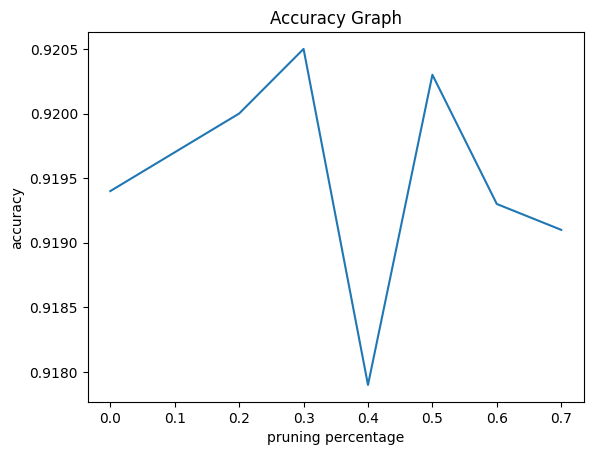

In [36]:
print(percent_arr)
print(percent_accuracy_list)
plt.plot(percent_arr, percent_accuracy_list)
plt.xlabel('pruning percentage')
plt.ylabel('accuracy')
plt.title('Accuracy Graph')
plt.show()

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
[20034413, 16045324, 12129210, 8794382, 6136866, 4098655, 2665752, 1748455]


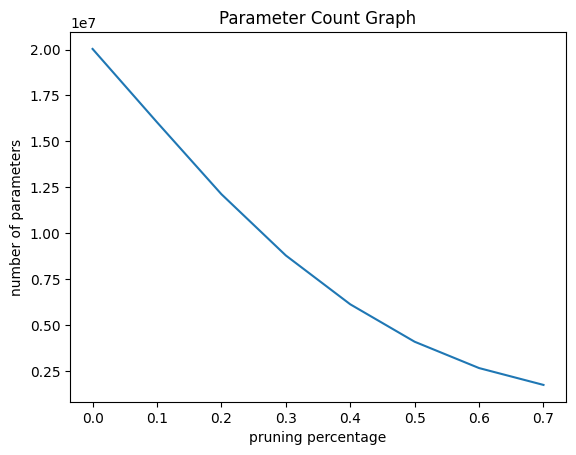

In [37]:
print(percent_arr)
print(percent_num_param_list)
plt.plot(percent_arr, percent_num_param_list)
plt.xlabel('pruning percentage')
plt.ylabel('number of parameters')
plt.title('Parameter Count Graph')
plt.show()

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
[76.49795722961426, 61.27487373352051, 46.33175849914551, 33.60629463195801, 23.464021682739258, 15.685213088989258, 10.215120315551758, 6.711153030395508]


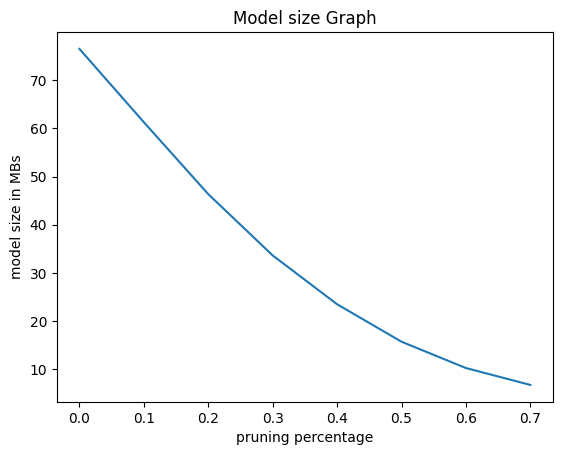

In [39]:
print(percent_arr)
print(percent_model_size_list)
plt.plot(percent_arr, percent_model_size_list)
plt.xlabel('pruning percentage')
plt.ylabel('model size in MBs')
plt.title('Model size Graph')
plt.show()